# Census Tract Data with Median Income

This notebook downloads Census TIGER tract shapefiles and ACS 5-Year median household income data.

**Important**: Run the cells in order, starting with the configuration cell below.

In [1]:
# Enable IPython autoreload for modules
%load_ext autoreload
%autoreload 2

import pandas as pd 
# Load configuration
data_dir = None # TO silence Pylance, data_dir is defined by the cofig.py file. 
%run ../../config.py




Project root: /Users/eric/proj/wireless-income
Data directory: /Users/eric/proj/wireless-income/data


In [2]:
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [3]:
from pathlib import Path
from subprocess import run

# URL for 2024 tract cartographic boundary file
tract_carto = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_tract_500k.zip"

tracts_fn = Path(tract_carto).name
tracts_path = Path(data_dir) / tracts_fn

if not tracts_path.exists():
    print(f"Downloading {tracts_fn}...")
    result = run(["wget", "-P", data_dir, tract_carto], capture_output=True, text=True)
    if result.returncode == 0:
        print(f"Downloaded to {tracts_path}")
    else:
        print(f"Error downloading: {result.stderr}")
else:
    print(f"{tracts_fn} already exists at {tracts_path}")

# Load the tract shapefile

tracts_gdf = gpd.read_file(tracts_path)

tracts_gdf.head()

cb_2022_us_tract_500k.zip already exists at /Users/eric/proj/wireless-income/data/cb_2022_us_tract_500k.zip


,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,06,077,005127,1400000US06077005127,06077005127,51.27,Census Tract 51.27,CA,San Joaquin County,California,CT,1960015,0,"POLYGON ((-121.28708 37.83381, -121.28499 37.8..."
1,06,077,003406,1400000US06077003406,06077003406,34.06,Census Tract 34.06,CA,San Joaquin County,California,CT,839414,14789,"POLYGON ((-121.309 38.02824, -121.30461 38.028..."
2,06,077,004402,1400000US06077004402,06077004402,44.02,Census Tract 44.02,CA,San Joaquin County,California,CT,4346363,0,"POLYGON ((-121.27338 38.10811, -121.27286 38.1..."
3,06,077,001700,1400000US06077001700,06077001700,17,Census Tract 17,CA,San Joaquin County,California,CT,1685934,0,"POLYGON ((-121.26642 37.9753, -121.26453 37.97..."
4,06,077,000401,1400000US06077000401,06077000401,4.01,Census Tract 4.01,CA,San Joaquin County,California,CT,1045658,0,"POLYGON ((-121.31334 37.96416, -121.30553 37.9..."


In [4]:
# Get Census data - 2022 ACS 5-Year median household income by tract
# B19013_001E is median household income
# We'll get all tracts in all states

print("Fetching ACS 5-Year median household income data by tract...")

# Get state FIPS codes first
states_url = "https://api.census.gov/data/2022/acs/acs5?get=NAME&for=state:*"
states_response = requests.get(states_url)
states_data = states_response.json()
state_fips = set([row[1] for row in states_data[1:]])  # Skip header

print(f"Found {len(state_fips)} states/territories")

# Fetch median income for all tracts in each state
all_tracts = []

for i, state_fips_code in enumerate(state_fips):  # Get all states
    try:
        url = f"https://api.census.gov/data/2022/acs/acs5?get=NAME,B19013_001E&for=tract:*&in=state:{state_fips_code}"
        response = requests.get(url)
        data = response.json()
        
        # Convert to dataframe
        df = pd.DataFrame(data[1:], columns=data[0])
        all_tracts.append(df)
        print(f"  State {state_fips_code}: {len(df)} tracts")
    except Exception as e:
        print(f"  Error fetching state {state_fips_code}: {e}")

# Combine all data
income_df = pd.concat(all_tracts, ignore_index=True)

# Clean up the data
income_df['median_income'] = pd.to_numeric(income_df['B19013_001E'], errors='coerce')
income_df['GEOID'] = income_df['state'] + income_df['county'] + income_df['tract']

income_df.head()


Fetching ACS 5-Year median household income data by tract...
Found 52 states/territories
  State 28: 878 tracts
  State 54: 546 tracts
  State 31: 553 tracts
  State 15: 461 tracts
  State 10: 262 tracts
  State 41: 1001 tracts
  State 19: 896 tracts
  State 40: 1205 tracts
  State 13: 2796 tracts
  State 12: 5160 tracts
  State 36: 5411 tracts
  State 27: 1505 tracts
  State 33: 350 tracts
  State 18: 1696 tracts
  State 01: 1437 tracts
  State 17: 3265 tracts
  State 35: 612 tracts
  State 56: 160 tracts
  State 39: 3168 tracts
  State 34: 2181 tracts
  State 44: 250 tracts
  State 48: 6896 tracts
  State 22: 1388 tracts
  State 50: 193 tracts
  State 04: 1765 tracts
  State 24: 1475 tracts
  State 55: 1542 tracts
  State 25: 1620 tracts
  State 26: 3017 tracts
  State 37: 2672 tracts
  State 47: 1701 tracts
  State 11: 206 tracts
  State 16: 456 tracts
  State 21: 1306 tracts
  State 09: 884 tracts
  State 30: 319 tracts
  State 72: 981 tracts
  State 45: 1323 tracts
  State 51: 219

,NAME,B19013_001E,state,county,tract,median_income,GEOID
0,Census Tract 1.01; Adams County; Mississippi,43525,28,001,000101,43525,28001000101
1,Census Tract 1.02; Adams County; Mississippi,40634,28,001,000102,40634,28001000102
2,Census Tract 2; Adams County; Mississippi,36537,28,001,000200,36537,28001000200
3,Census Tract 3; Adams County; Mississippi,28750,28,001,000300,28750,28001000300
4,Census Tract 4; Adams County; Mississippi,17083,28,001,000400,17083,28001000400


In [5]:
# Join income data to tract geometries
print("Joining income data to tract shapefile...")

tracts_with_income = tracts_gdf.merge(
    income_df[['GEOID', 'median_income', 'NAME']], 
    on='GEOID', 
    how='left',
    suffixes=('_tract', '_income')
)

print(f"\nTracts with income data: {tracts_with_income['median_income'].notna().sum()}")
print(f"Tracts without income data: {tracts_with_income['median_income'].isna().sum()}")

# Filter to include only states that are in state_fips, then exclude Alaska (02) and Hawaii (15)
df = tracts_with_income_filtered = tracts_with_income[
    (tracts_with_income['STATEFP'].isin(state_fips)) & 
    (~tracts_with_income['STATEFP'].isin(['02', '15']))
]

df = df[df.median_income > 0]

df.head()

Joining income data to tract shapefile...



Tracts with income data: 85059
Tracts without income data: 126


,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME_tract,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER,geometry,median_income,NAME_income
0,06,077,005127,1400000US06077005127,06077005127,51.27,Census Tract 51.27,CA,San Joaquin County,California,CT,1960015,0,"POLYGON ((-121.28708 37.83381, -121.28499 37.8...",102440.0,Census Tract 51.27; San Joaquin County; Califo...
1,06,077,003406,1400000US06077003406,06077003406,34.06,Census Tract 34.06,CA,San Joaquin County,California,CT,839414,14789,"POLYGON ((-121.309 38.02824, -121.30461 38.028...",38497.0,Census Tract 34.06; San Joaquin County; Califo...
2,06,077,004402,1400000US06077004402,06077004402,44.02,Census Tract 44.02,CA,San Joaquin County,California,CT,4346363,0,"POLYGON ((-121.27338 38.10811, -121.27286 38.1...",89167.0,Census Tract 44.02; San Joaquin County; Califo...
3,06,077,001700,1400000US06077001700,06077001700,17,Census Tract 17,CA,San Joaquin County,California,CT,1685934,0,"POLYGON ((-121.26642 37.9753, -121.26453 37.97...",51083.0,Census Tract 17; San Joaquin County; California
4,06,077,000401,1400000US06077000401,06077000401,4.01,Census Tract 4.01,CA,San Joaquin County,California,CT,1045658,0,"POLYGON ((-121.31334 37.96416, -121.30553 37.9...",57500.0,Census Tract 4.01; San Joaquin County; California


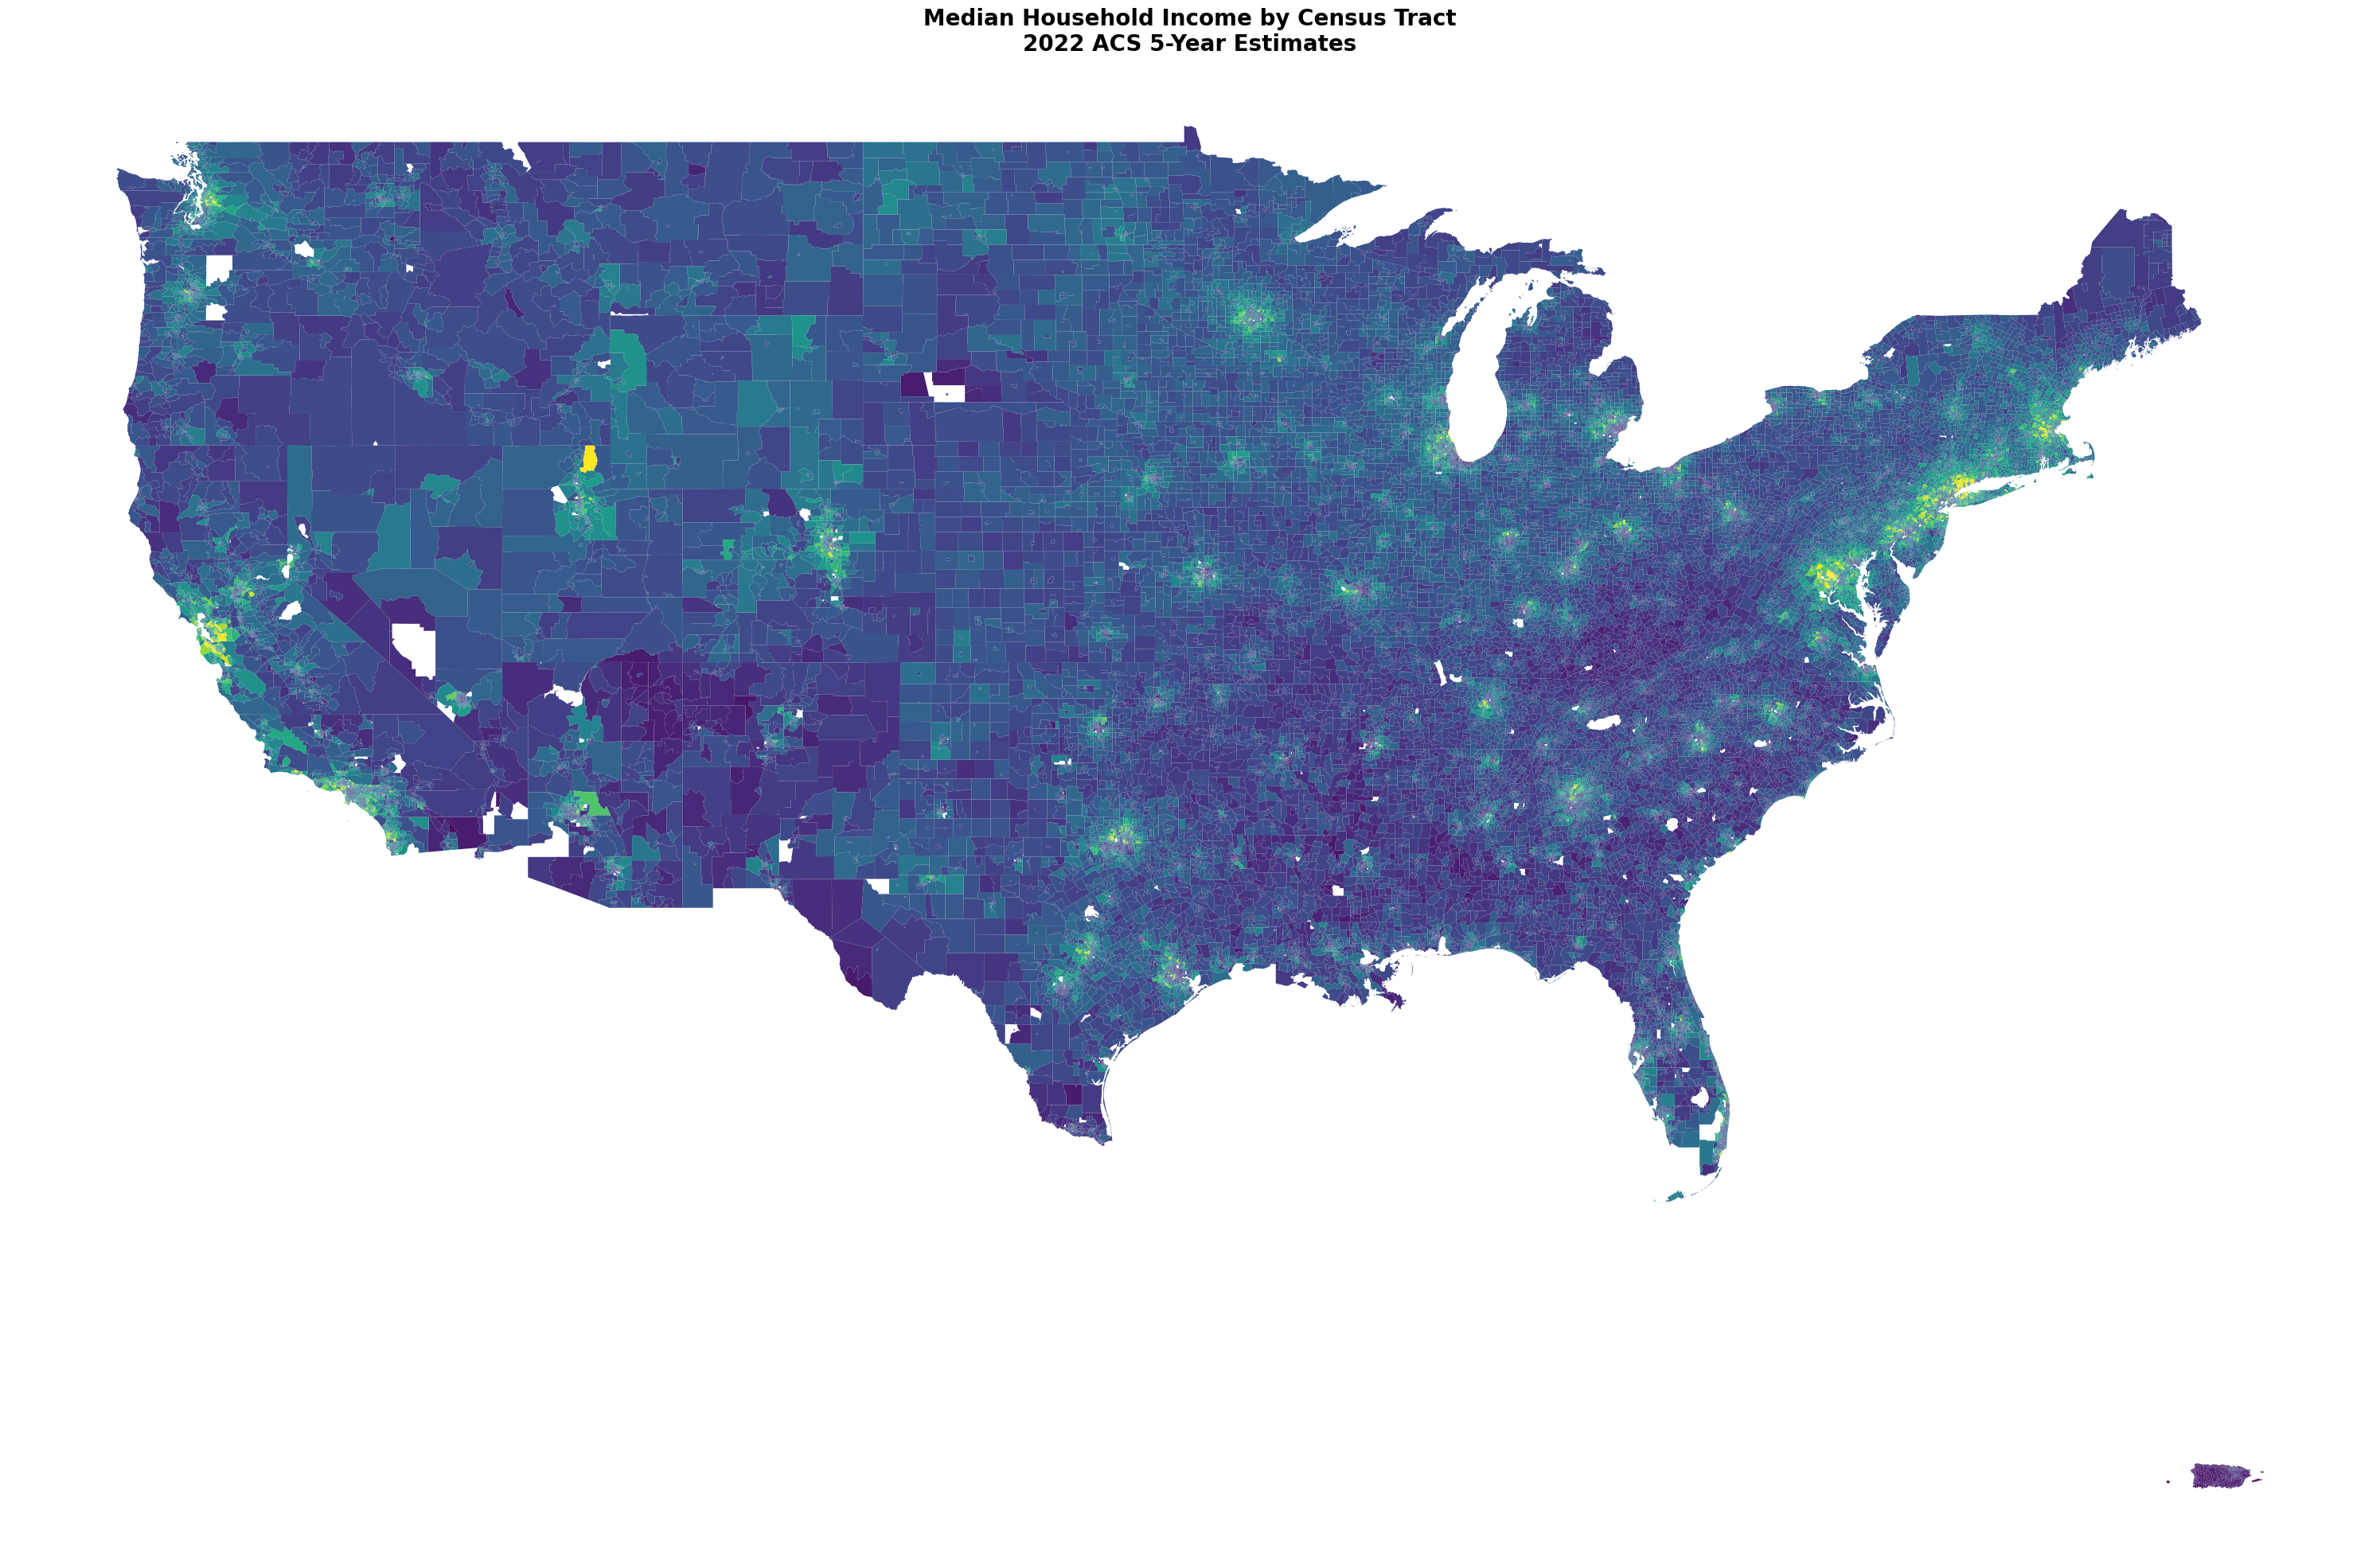

In [6]:

# Create map using GeoPandas plot method
fig, ax = plt.subplots(figsize=(30, 20))

# Use GeoPandas native plot without legend
df.plot(
    column='median_income',
    ax=ax,
    legend=False,
    cmap='viridis',
    missing_kwds={'color': 'lightgrey'}
)

ax.set_title('Median Household Income by Census Tract\n2022 ACS 5-Year Estimates', 
             fontsize=20, fontweight='bold')
ax.set_axis_off()

plt.tight_layout()
plt.show()


<Axes: >

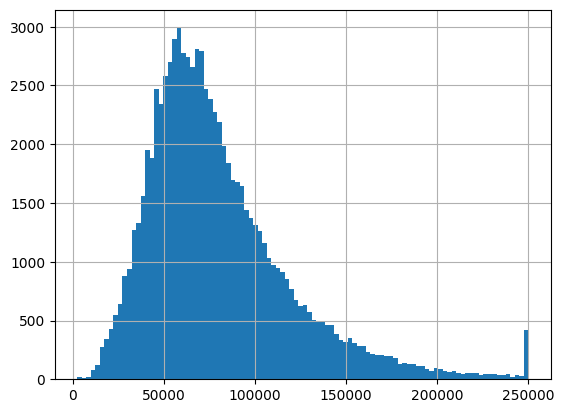

In [7]:
df.median_income.hist(bins=100)

In [10]:
df[df.median_income>0].median_income.describe()

count     83225.000000
mean      80002.532761
std       39652.896547
min        2499.000000
25%       53043.000000
50%       71392.000000
75%       97894.000000
max      250001.000000
Name: median_income, dtype: float64

In [11]:
# Save joined tracts with income to Parquet in data_dir
import os

output_path = os.path.join(data_dir, "tracts_with_income_2022.parquet")
df.to_parquet(output_path)
print(f"Saved {len(df)} rows to {output_path}")

Saved 83225 rows to /Users/eric/proj/wireless-income/data/tracts_with_income_2022.parquet
